# Curriculum NeRF

The implementation is based on [this repository](https://github.com/ActiveVisionLab/nerfmm)

In [ ]:
# imports
import os, random, datetime
import torch
import torch.nn as nn

from torch.nn import Module,Conv2d,Linear,MaxPool2d,ReLU

import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
import tqdm
from IPython.display import Image

# local imports
from poses import make_c2w, create_spiral_poses
from rendering import comp_ray_dir_cam_fxfy, volume_rendering, volume_sampling_ndc, mse2psnr

### Load Images

Loaded 106 imgs, resolution 100 x 100
images shape: torch.Size([106, 100, 100, 3])
poses shape: (106, 4, 4)
focal length: 138.88887889922103


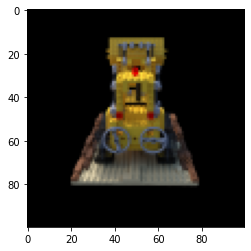

In [3]:
# Load lego data (from https://www.matthewtancik.com/nerf)
data = np.load('tiny_nerf_data.npz')
poses = data['poses']
focal = data['focal']

images = torch.from_numpy(data['images']).float()  # (N, H, W, 3) torch.float32
N_imgs, H, W = images.shape[:3]


print(f'Loaded {N_imgs} imgs, resolution {H} x {W}')
print("images shape:", images.shape)
print("poses shape:", poses.shape)
print("focal length:", focal)
plt.imshow(images[0]);

Look at where the pictures are taken from

In [4]:
def poseToPosition(pose):
    """
    pose: (4, 4) extrinsic parameter pose
    """
    assert(pose[3, 3] == 1)
    assert((pose[3, :3] == 0).all())
    R = pose[:3, :3]
    T = pose[:3, 3]
    #dir = R.T @ np.array([0, 0, 1]) # does not seem to be correct
    return T

poses_pos = np.array([poseToPosition(p) for p in poses])
print(poses[0])
print(poses_pos[0])

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[-0.05379832  3.8454704   1.2080823 ]


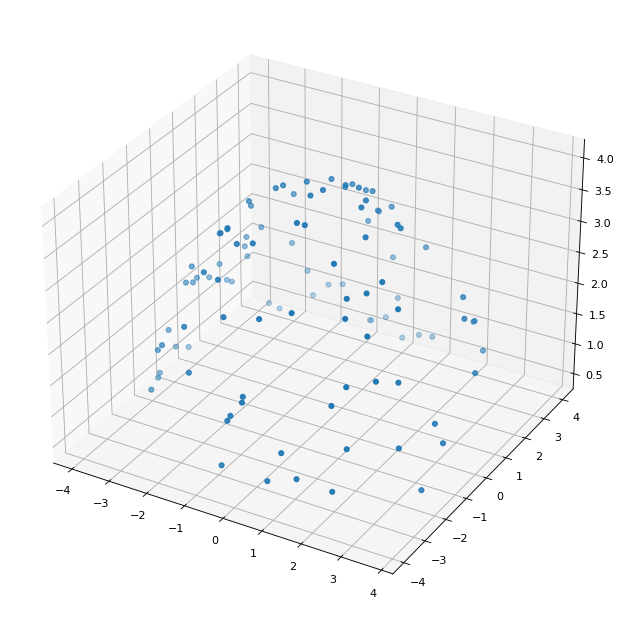

In [5]:
plt.figure(dpi=80, figsize=(10, 10))
ax = plt.subplot(111, projection='3d')
#ax.scatter([0], [0], [0], c='b', marker='o', s=500)
#ax.set_zlim(bottom=0)
ax.scatter(poses_pos[:,0], poses_pos[:,1], poses_pos[:,2]);
s = -0.15
#ax.quiver3D(poses_pos[:,0], poses_pos[:,1], poses_pos[:,2],
#            s*poses_pos[:,0], s*poses_pos[:,1], s*poses_pos[:,2]);

### Batching images according to position

In [6]:
# use spherical coordinates (physics convention)
poses_phi = np.arctan2(poses_pos[:,1], poses_pos[:,0])
poses_theta = np.arctan2(poses_pos[:,2], np.sqrt(poses_pos[:,0]**2 + poses_pos[:,1]**2))

def getBatches(num_batches_bot):
    # sort by theta
    #condition_top = poses_pos[:,2] >= 1
    condition_top = poses_theta >= 45*np.pi/180
    batch_top = np.where(condition_top)[0]
    not_top = np.where(~condition_top)[0]

    idx_sort = np.argsort(poses_phi[not_top])
    not_top_sort = not_top[idx_sort]

    batches_bot = np.array_split(not_top_sort, num_batches_bot)
    batches = [batch_top] + batches_bot
    #print("\n".join(map(str, batches)))
    return batches

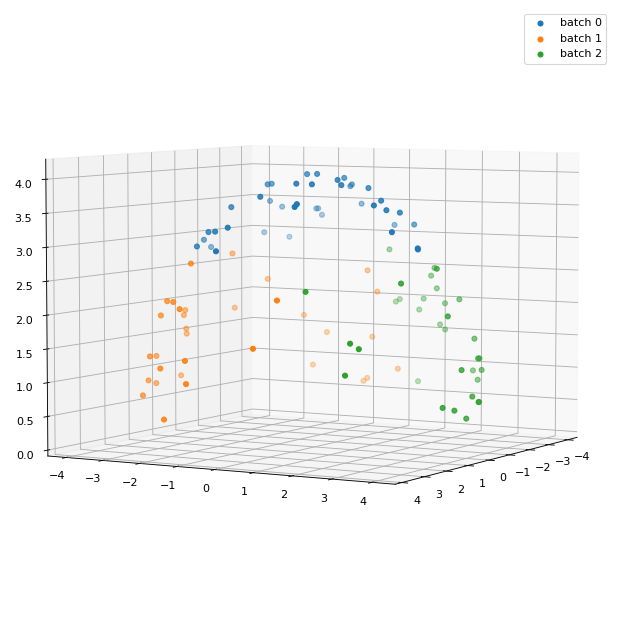

In [7]:
batches_vis = getBatches(2)
# display batches colored in 3d
plt.figure(dpi=80, figsize=(10, 10))
ax = plt.subplot(111, projection='3d')
ax.view_init(5, 30)
for i, batch in enumerate(batches_vis[:]):
    ax.scatter(poses_pos[batch,0], poses_pos[batch,1], poses_pos[batch,2], label=f'batch {i}')
ax.set_zlim(bottom=0)
plt.legend()
plt.show()

Make sure pictures from the same badge show similar viewing angles

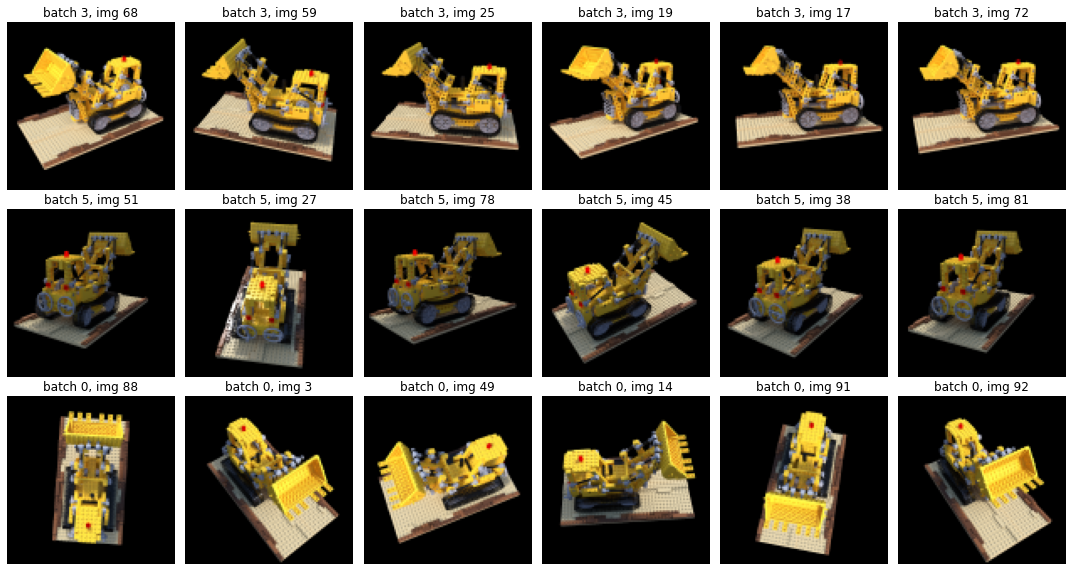

In [8]:
batches = getBatches(6)
min_batch_size = min(map(len, batches))

batches_vis_indx = [3, 5, 0]
fig, axs = plt.subplots(len(batches_vis_indx), min(6, min_batch_size), figsize=(15, 8))
for i, batch_i in enumerate(batches_vis_indx):
    batch_sample = np.random.choice(batches[batch_i], min(6, len(batches[batch_i])), replace=False)
    for j, indx in enumerate(batch_sample):
        ax = axs[i, j]
        ax.imshow(images[indx])
        ax.axis('off')
        ax.set_title(f'batch {batch_i}, img {indx}')
fig.tight_layout();

### Camera pos conversions

In [9]:
class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, cam_id):
        r = self.r[cam_id]  # (3, ) axis-angle
        t = self.t[cam_id]  # (3, )
        c2w = make_c2w(r, t)  # (4, 4)
        return c2w

## Model

In [10]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )

        self.fc_density = nn.Linear(D, 1)
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

In [11]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 0.0, 6.0  # ndc near far
      self.N_SAMPLE = 128  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

ray_params = RayParameters()

### Training

In [12]:
def encode_position(input, levels, inc_input):
    """
    For each scalar, we encode it using a series of sin() and cos() functions with different frequency.
        - With L pairs of sin/cos function, each scalar is encoded to a vector that has 2L elements. Concatenating with
          itself results in 2L+1 elements.
        - With C channels, we get C(2L+1) channels output.
    :param input:   (..., C)            torch.float32
    :param levels:  scalar L            int
    :return:        (..., C*(2L+1))     torch.float32
    """

    # this is already doing 'log_sampling' in the official code.
    result_list = [input] if inc_input else []
    for i in range(levels):
        temp = 2.0**i * input  # (..., C)
        result_list.append(torch.sin(temp))  # (..., C)
        result_list.append(torch.cos(temp))  # (..., C)

    result_list = torch.cat(result_list, dim=-1)  # (..., C*(2L+1)) The list has (2L+1) elements, with (..., C) shape each.
    return result_list  # (..., C*(2L+1))

def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result


def train_one_epoch(imgs, g_ids, H, W, ray_params, opt_nerf, fxfy,
                    opt_pose, nerf_model, pose_param_net):
    nerf_model.train()
    pose_param_net.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(len(imgs))
    np.random.shuffle(ids)

    for i, g_id in enumerate(g_ids):

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        img = imgs[i].to('cuda')  # (H, W, 4)
        c2w = pose_param_net(g_id)  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_pose.step()
        opt_nerf.zero_grad()
        opt_pose.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

### Evaluation
Render from a new viewpoint

In [13]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

## Training

In [1]:
N_EPOCH = 200  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
pose_param_net = LearnPose(num_cams=N_imgs, learn_R=True, learn_t=True).cuda()

# Get a tiny NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

scene_name = "Lego"
# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

FOCAL_LENGTH = focal
fxfy = torch.tensor([W, H], dtype=torch.float32).cuda() / W * FOCAL_LENGTH

# Training
print('Training... Check results in the tensorboard above.')

batch_i = 3
batch = batches[batch_i]
imgs = images[batch]

for epoch_i in tqdm(range(N_EPOCH), desc='Training'):

    L2_loss = train_one_epoch(imgs, batch, H, W, ray_params, opt_nerf, fxfy,
                              opt_pose, nerf_model, pose_param_net)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_imgs)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

NameError: name 'LearnPose' is not defined

## New Viewpoint

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in batch])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

In [ ]:
Image(open(os.path.join('nvs_results', scene_name + '_img.gif'), 'rb').read())

In [ ]:
Image(open(os.path.join('nvs_results', scene_name + '_depth.gif'), 'rb').read())